<a href="https://colab.research.google.com/github/YUMVOLKOVA/dul_2021/blob/main/hw11/Homework11_selfsupervised2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 361, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 361 (delta 112), reused 93 (delta 65), pack-reused 163
Receiving objects: 100% (361/361), 55.77 MiB | 31.75 MiB/s, done.
Resolving deltas: 100% (169/169), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=26856 sha256=67245cd42aa032cfde26d7b37464c578e1aa67518ca17f0b05e2a7406e11371a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ghizfiob/wheels/55/59/29/0fb1c6356521

In [11]:
from dul_2021.utils.hw11_utils import *

# Question 1. BYOL

Here we will implement [BYOL](https://arxiv.org/abs/2006.07733).

* You can combine view, representation, and projection into one network. You can use same architechure as in practice. 

* Use BatchNorm

* As predictor use few linear layers

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* τ = 0.99 (target update coefficient)
* lr = 1e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
import torch.optim as opt
import numpy as np
from copy import deepcopy
from torch.optim import Adam
import torchvision
from torchvision import transforms

from tqdm.notebook import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
params = {'tuc': 0.99,
          'lr': 1e-4,
          'num_epochs': 20,
          'latent_dim': 128,
          'batch_size': 256}

In [13]:
class Net(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim_full, conv_to_fc = 7 * 7 * 4):
        super(Net, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim_full = hid_dim_full
        self.conv_to_fc = conv_to_fc

        self.conv1 = nn.Conv2d(in_dim, 16, 5, padding=2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding=1, stride=2)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1, stride=2)
        self.conv5 = nn.Conv2d(32, 32, 1)
        self.conv6 = nn.Conv2d(32, 4, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn3 = nn.BatchNorm2d(32)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(32)
        self.bn6 = nn.BatchNorm2d(4)

        self.fc1 = nn.Linear(self.conv_to_fc, self.hid_dim_full)
        self.fc2 = nn.Linear(self.hid_dim_full, int(self.hid_dim_full // 2))

        self.features = nn.Linear(int(self.hid_dim_full // 2), self.out_dim)


    def forward(self, x):
    
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))

        x = x.view(-1, self.conv_to_fc)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        features = self.features(x)

        return features

In [47]:
class BYOL(nn.Module):
  def __init__(self, in_dim, out_dim, hid_dim_full):
    super().__init__()
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.hid_dim_full = hid_dim_full
    self.student = Net(self.in_dim, self.out_dim, self.hid_dim_full)
    self.teacher = deepcopy(self.student)
    self.teacher.requires_grad_(False)

    self.predictor = nn.Sequential(nn.Linear(self.out_dim, self.hid_dim_full),
                                    nn.ReLU(),
                                    nn.Linear(self.hid_dim_full, self.hid_dim_full),
                                    nn.BatchNorm1d(self.hid_dim_full), 
                                    nn.ReLU(),
                                    nn.Linear(self.hid_dim_full, self.out_dim))
    self.transformation = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(28),
                                          transforms.GaussianBlur(9),
                                          transforms.Normalize(0.5, 0.5)])
  
  def get_similarity(self, first_data, second_data):
    enc_student = self.student(first_data)
    enc_teacher = self.teacher(second_data)
    predict_student = self.predictor(enc_student)
    norm_predict_student = F.normalize(predict_student)
    norm_enc_teacher = F.normalize(enc_teacher)    
    similarity = F.mse_loss(norm_predict_student, norm_enc_teacher)
    return similarity 

  def fit(self, train_data, num_epochs, lr, tuc):
    params_student = list(self.student.parameters())
    params_predict = list(self.predictor.parameters())
    optimizer = Adam(params_student + params_predict, lr=lr)

    loss = []

    for i in tqdm(range(num_epochs)):
      for batch in train_data:
        batch = batch[0].to(device)

        batch_for_student = self.transformation(batch)
        batch_for_teacher = self.transformation(batch)
        first_similarity = self.get_similarity(batch_for_student, batch_for_teacher)
        second_similarity = self.get_similarity(batch_for_teacher, batch_for_student)
        current_loss = first_similarity + second_similarity
        current_loss = current_loss.mean()

        optimizer.zero_grad()
        current_loss.backward()
        optimizer.step()

        with torch.no_grad():
          for i, j in zip(self.student.parameters(), self.teacher.parameters()):
            j.data.copy_(tuc * j.data + (1 - tuc) * i.data)

        loss.append(current_loss.item())
    loss = np.array(loss)
    return loss

  def encode(self, data):
    with torch.no_grad():
      self.student.eval()
      out = self.student(data.to(device))
      self.student.train()
    return out


In [49]:
def q1(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    train = DataLoader(train_data, 
                       batch_size=params['batch_size'],
                       shuffle=True)    

    model_BYOL = BYOL(in_dim=1, 
                      out_dim=params['latent_dim'], 
                      hid_dim_full=params['latent_dim'])
    model_BYOL = model_BYOL.to(device)
    print('done with init')

    loss = model_BYOL.fit(train,
                          num_epochs=params['num_epochs'],
                          lr=params['lr'],
                          tuc=params['tuc'])  
    print('done with losses')  
    encode_out = model_BYOL.encode
    print('done with encode')
    return loss, encode_out
    

done with init


  0%|          | 0/20 [00:00<?, ?it/s]

done with losses
done with encode
mean classification accuracy=0.6496


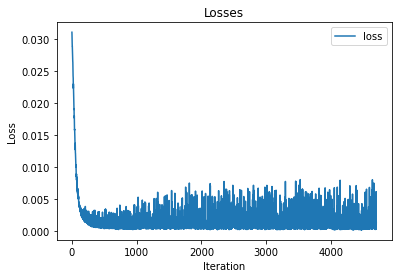

In [50]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q1_results(q1, True)

In [ ]:
# q1_results(q1, False)

# Question 2. Barlow Twins

Here we will implement [barlow twins](https://arxiv.org/abs/2103.03230).

* You can use same architechure as in practice. 

* Dataset comes untransformed, so you need to apply transformations during training by yourself. Use same augmentations as in SimCLR

**Hyperparameters**

* λ = 0.01 
* lr = 5e-4
* num_epochs = 20
* latent dim = 128



**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [14]:
params = {'lambda': 0.01,
          'lr': 5e-4,
          'num_epochs': 20,
          'latent_dim': 128,
          'batch_size': 256}

In [30]:
class Barlow_Twins(nn.Module):
  def __init__(self, latent_dim, lambd):
    super().__init__()
    self.latent_dim = latent_dim
    self.lambd = lambd
    self.model = Net(in_dim=3, 
                    out_dim=self.latent_dim, 
                    hid_dim_full=self.latent_dim)
    self.transformation = transforms.Compose([transforms.RandomHorizontalFlip(),
                                              transforms.RandomResizedCrop(28),
                                              transforms.GaussianBlur(9),
                                              transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.5, 0.1)], p=0.8),
                                              transforms.RandomGrayscale(0.2),
                                              transforms.Normalize(0.5, 0.5)])

  def forward(self, data):
    output = self.model(data)
    return output

  def fit(self, train_data, num_epochs, lr):
    optimizer = Adam(self.parameters(), lr=lr)
    loss = []

    for i in tqdm(range(num_epochs)):
      for batch in train_data:
        batch = batch[0].to(device)
        size = batch.shape[0]

        y_1 = self.transformation(batch)
        z_1 = self.forward(y_1)
        z_1_norm = (z_1 - z_1.mean(0)) / z_1.std(0)

        y_2 = self.transformation(batch)
        z_2 = self.forward(y_2)
        z_2_norm = (z_2 - z_2.mean(0)) / z_2.std(0)

        c = (z_1_norm.T @ z_2_norm).div_(size)
        size_c = c.shape[0]

        loss_diag = torch.diagonal(c).add_(-1)
        loss_diag = torch.pow(loss_diag, 2)
        loss_diag = torch.sum(loss_diag)

        loss_out_diag = c.flatten()[: -1]
        # print(loss_out_diag.shape)
        loss_out_diag = loss_out_diag.view(size_c - 1, size_c + 1)[:, 1:]
        # print(loss_out_diag.shape)
        loss_out_diag = loss_out_diag.flatten()
        # print(loss_out_diag.shape)
        loss_out_diag = torch.pow(loss_out_diag, 2)
        loss_out_diag = torch.sum(loss_out_diag)

        corrent_loss = loss_diag + self.lambd * loss_out_diag

        optimizer.zero_grad()
        corrent_loss.backward()
        optimizer.step()

        loss.append(corrent_loss.item())
    loss = np.array(loss)
    return loss

  def encode(self, data):
    with torch.no_grad():
      self.eval()
      out = self(data.to(device))
      self.train()
    return out


In [31]:
def q2(train_data, test_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """
    train = DataLoader(train_data, 
                       batch_size=params['batch_size'],
                       shuffle=True)
    model_Barlow_Twins = Barlow_Twins(latent_dim=params['latent_dim'], 
                                      lambd=params['lambda'])
    model_Barlow_Twins = model_Barlow_Twins.to(device)
    print('done with init')    
    loss = model_Barlow_Twins.fit(train, 
                                  num_epochs=params['num_epochs'], 
                                  lr=params['lr'])
    print('done with losses')
    encoder = model_Barlow_Twins.encode
    print('done with encode')
    return loss, encoder


In [ ]:
# change flag to False if you want only to test your losses w/o accuracy (it takes around 4-5 minutes)
q2_results(q2, True)

Files already downloaded and verified
Files already downloaded and verified
done with init


  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
q2_results(q2, False)

# Bonus. SwAV

Here we will implement [SwAV](https://arxiv.org/abs/2006.09882v5)

**You will provide the following deliverables**


1. Over the course of training, record loss ber batch.
2. A function that encodes a batch of images with your trained model. The function recieves a batch torch tensors on cpu and should return transformed 2d tensor (batch size x laten dim). It will be used to test representation on classification task.

In [ ]:
def b(train_data):
    """
    train_data: An (n_train, 1, 32, 32) torchvision dataset of CIFAR10 images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array  losses on each iteration
    - a function that transforms batch of images into their latent representation
    """

In [ ]:
q2_results(b, True)